### can run this one by one interactively or, as a batch, run `../scripts/general_postproc.py`

In [1]:
import sys
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import zipfile
sys.path.insert(0,'../scripts/')
from postprocessing import setup_postproc, check_pdc, plot_phi, get_obs_and_noise, get_pars, plot_group, plot_pars_group

/Users/mnfienen/Documents/GIT/hytest/NHM_CAL/nhm_pestpp/notebooks/../dependencies/pyemu/pst/pst_handler.py:15: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


In [2]:
# curr_model = '01473000'
curr_model = '05431486'
# curr_model = '09112500'
curr_run_root = 'prior_mc_reweight'
eval_pdc = True
unzip_dirs = True
phi_cutoffs = {cm:{crr:9e99 for crr in ['ies','prior_mc_reweight']}
                for cm in ['01473000','05431486', '09112500']}
pstdir, results_file, tmp_res_path, fig_dir, obs, pst = setup_postproc(curr_model, curr_run_root, unzip_dirs)

error parsing metadata from 'obsnme', continuing


### check out PDC

In [3]:
pst.nnz_obs_groups

['g_min_actet_mean_mon',
 'g_min_actet_mon',
 'g_min_recharge_ann',
 'g_min_runoff_mon',
 'g_min_sca_daily',
 'g_min_soil_moist_ann',
 'g_min_soil_moist_mon',
 'l_max_actet_mean_mon',
 'l_max_actet_mon',
 'l_max_recharge_ann',
 'l_max_runoff_mon',
 'l_max_sca_daily',
 'l_max_soil_moist_ann',
 'l_max_soil_moist_mon',
 'streamflow_daily_large_asc',
 'streamflow_daily_large_dsc',
 'streamflow_daily_small_asc',
 'streamflow_daily_small_dsc',
 'streamflow_daily_pulse_asc',
 'streamflow_daily_pulse_dsc',
 'streamflow_daily_low',
 'streamflow_daily_exlow',
 'streamflow_mean_mon',
 'streamflow_mon']

In [4]:
if eval_pdc:
    pdc = check_pdc(tmp_res_path, curr_run_root, pst, obs)
    print(pdc)

9.31% of weighted obs are in PDC
                            obs_counts  pdc_counts group_percent_pdc
obgnme                                                              
g_min_actet_mean_mon               192         2.0             1.04%
g_min_actet_mon                   2112        74.0             3.50%
g_min_recharge_ann                 160        34.0            21.25%
g_min_runoff_mon                  5568         6.0             0.11%
g_min_sca_daily                  53376       584.0             1.09%
g_min_soil_moist_ann               464         3.0             0.65%
g_min_soil_moist_mon              5568       383.0             6.88%
l_max_actet_mean_mon               192         NaN              nan%
l_max_actet_mon                   2112         7.0             0.33%
l_max_recharge_ann                 160         NaN              nan%
l_max_runoff_mon                  5568         NaN              nan%
l_max_sca_daily                  53376       697.0             1.31%
l

### look at PHI history

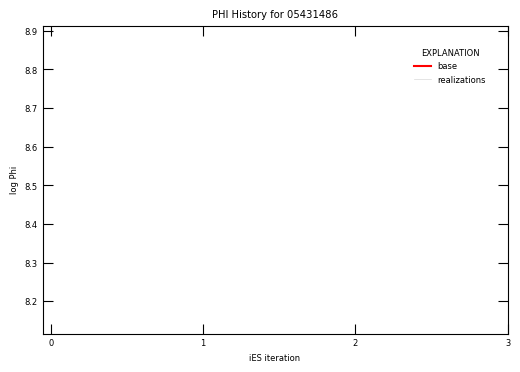

In [5]:
phi = plot_phi(tmp_res_path, curr_run_root, curr_model, fig_dir)

### Truncate PHI at a threshold

In [6]:
phi

,total_runs,mean,standard_deviation,min,max,0,1,2,3,4,...,490,491,492,493,494,495,496,497,498,base
iteration,,,,,,,,,,,,,,,,,,,,,
0,500,386410000.0,116873000.0,142065000.0,754124000.0,708792000.0,633400000.0,387829000.0,429565000.0,371521000.0,...,419044000.0,685919000.0,233112000.0,453278000.0,393805000.0,320614000.0,381336000.0,432585000.0,385324000.0,142065000.0


In [7]:
best_iter = 0
if 'prior' in curr_run_root:
    best_iter = 0
best_iter

0

## now rejection sampling for outlier PHI values

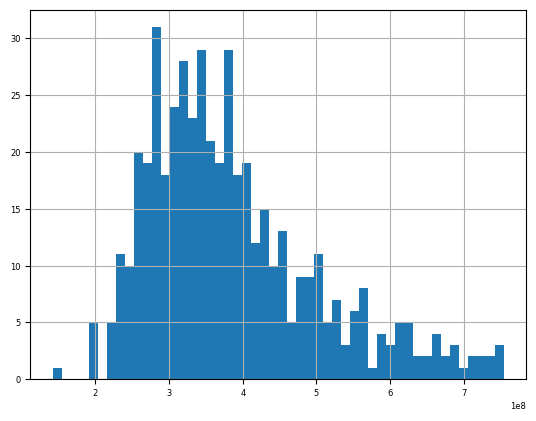

In [8]:
orgphi = phi.loc[best_iter].iloc[5:].copy()
ax = orgphi.hist(bins=50)
lims = ax.get_xlim()

In [9]:
# catalog of cutoffs heuristically determined
phi_cutoffs['01473000']['prior_mc_reweight'] = 4.0e7
phi_cutoffs['01473000']['ies'] = 1.08e9
phi_cutoffs['05431486']['prior_mc_reweight'] = 5.7e8
phi_cutoffs['05431486']['ies'] = 7.5e8
phi_cutoffs['09112500']['prior_mc_reweight'] = 1.2e9
phi_cutoffs['09112500']['ies'] = 8.675e8

In [10]:
phi_too_high = phi_cutoffs[curr_model][curr_run_root]
phi_too_high

570000000.0

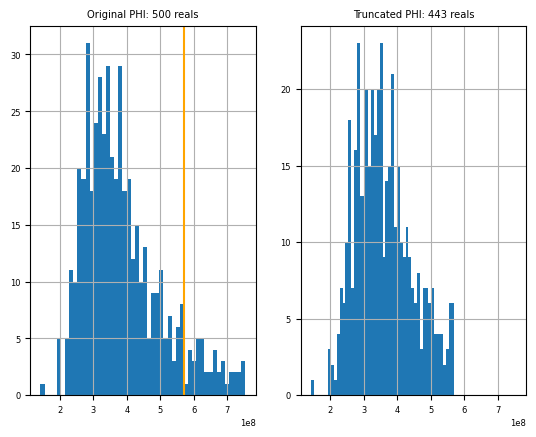

In [11]:
phi = orgphi.loc[orgphi<=phi_too_high]
fig,ax = plt.subplots(1,2)
### --> need to indicate which reals we will carry forward <-- ###
orgphi.hist(bins=50, ax=ax[0])
reals = phi.index 
phi.hist(bins=50, ax=ax[1])
ax[0].axvline(phi_too_high, color='orange')
ax[1].set_xlim(lims)
ax[0].set_title(f'Original PHI: {len(orgphi)} reals')
ax[1].set_title(f'Truncated PHI: {len(phi)} reals')
plt.savefig(fig_dir/ 'phi_histogram.pdf')


In [ ]:
reals

### make example data for the evaluation team

In [ ]:
# obens = pd.read_csv(tmp_res_path / f'{curr_run_root}.{best_iter}.obs.csv', 
#                     low_memory=False, index_col=0).loc[reals].T
# obens_noise = pd.read_csv(tmp_res_path / f'{curr_run_root}.obs+noise.csv', 
#                           low_memory=False, index_col=0).loc[reals].T
# ex_data = obens['base'].to_frame().rename(columns={'base':'modelled'})
# ex_data['measured'] = obens_noise.loc[ex_data.index,'base']
# ex_data['group'] = obs.loc[ex_data.index,'obgnme']
# ex_data['weight'] = obs.loc[ex_data.index,'weight']
# ex_data['standard_deviation'] = obs.loc[ex_data.index,'standard_deviation']
# ex_data.to_csv(f'../evaluation/example_data/{curr_model}.prior.csv.zip')

### now read in and trim hotstart files

In [ ]:
parens = pd.read_csv(tmp_res_path / f'{curr_run_root}.{best_iter}.par.csv',
                         index_col=0, low_memory=False).loc[reals]

In [ ]:
parens.index = [str(i) for i in range(len(parens)-1)] + ['base']

In [ ]:
parens.to_csv(pstdir / 'hotstart.starting_pars.csv.zip')

In [ ]:
obens = pd.read_csv(tmp_res_path / f'{curr_run_root}.{best_iter}.obs.csv', 
                    low_memory=False, index_col=0).loc[reals]
obens.index = parens.index
obens_noise = pd.read_csv(tmp_res_path / f'{curr_run_root}.obs+noise.csv', 
                          low_memory=False, index_col=0).loc[reals]
obens_noise.index = parens.index

In [ ]:
obens.to_csv(pstdir / 'hotstart.starting_obs.csv.zip')
obens_noise.to_csv(pstdir / 'hotstart.starting_obs+noise.csv.zip')


In [ ]:
pst.control_data.noptmax=2
pst.pestpp_options["ies_num_reals"] = len(reals)
pst.pestpp_options["ies_observation_ensemble"] = 'hotstart.starting_obs+noise.csv'
pst.pestpp_options["ies_restart_observation_ensemble"] = 'hotstart.starting_obs.csv'
pst.pestpp_options["ies_parameter_ensemble"] = 'hotstart.starting_pars.csv'

In [ ]:
pst.pestpp_options

In [ ]:
pst.write(str(pstdir / 'ies_hot.pst'), version=2)

In [ ]:
with zipfile.ZipFile(pstdir / f'{curr_model}.hotstart.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    [zipf.write(i, i.name) for i in pstdir.glob('hotstart.starting*.zip')]

In [ ]:
obs